In [1]:
import pandas as pd

test_cases = pd.read_csv("../../data/raw/sample_test_cases.csv")
defects = pd.read_csv("../../data/raw/sample_defects.csv")

test_cases.head(), defects.head()


(  test_case_id            project   release_id module sub_module  \
 0       TC_001         Brain Bits  REL_2025_04     FI         AR   
 1       TC_002         Brain Bits  REL_2025_04     FI         AP   
 2       TC_003  Cardiac Challenge  REL_2025_02     SD   Delivery   
 3       TC_004  Cardiac Challenge  REL_2025_02     MM         PO   
 4       TC_005      Black Panther  REL_2025_01     PP   Capacity   
 
                                         description priority  \
 0         Validate invoice creation for EU customer     High   
 1             Validate vendor payment run for LATAM   Medium   
 2  Validate delivery doc creation for export orders     High   
 3           Validate PO creation with new tax codes   Medium   
 4             Validate capacity planning run for Q1     High   
 
   last_execution_status last_execution_date  execution_count  failure_count  
 0                Failed          15-03-2025               10              4  
 1                Passed          

In [2]:
print("Test cases:", test_cases.shape)
print("Defects:", defects.shape)

print("\nTest case columns:", test_cases.columns.tolist())
print("Defect columns:", defects.columns.tolist())


Test cases: (5, 11)
Defects: (5, 10)

Test case columns: ['test_case_id', 'project', 'release_id', 'module', 'sub_module', 'description', 'priority', 'last_execution_status', 'last_execution_date', 'execution_count', 'failure_count']
Defect columns: ['defect_id', 'test_case_id', 'project', 'release_id', 'module', 'severity', 'defect_type', 'status', 'created_date', 'closed_date']


In [3]:
# Aggregate defects per test_case_id
defect_agg = (
    defects
    .groupby("test_case_id")
    .agg(
        defect_count=("defect_id", "count"),
        high_sev_defects=("severity", lambda s: (s == "High").sum())
    )
    .reset_index()
)

feature_df = test_cases.merge(defect_agg, on="test_case_id", how="left")
feature_df[["defect_count", "high_sev_defects"]] = feature_df[["defect_count", "high_sev_defects"]].fillna(0)

feature_df


,test_case_id,project,release_id,module,sub_module,description,priority,last_execution_status,last_execution_date,execution_count,failure_count,defect_count,high_sev_defects
0,TC_001,Brain Bits,REL_2025_04,FI,AR,Validate invoice creation for EU customer,High,Failed,15-03-2025,10,4,2.0,1.0
1,TC_002,Brain Bits,REL_2025_04,FI,AP,Validate vendor payment run for LATAM,Medium,Passed,16-03-2025,8,1,1.0,0.0
2,TC_003,Cardiac Challenge,REL_2025_02,SD,Delivery,Validate delivery doc creation for export orders,High,Failed,20-01-2025,12,5,1.0,1.0
3,TC_004,Cardiac Challenge,REL_2025_02,MM,PO,Validate PO creation with new tax codes,Medium,Passed,18-01-2025,6,0,0.0,0.0
4,TC_005,Black Panther,REL_2025_01,PP,Capacity,Validate capacity planning run for Q1,High,Failed,05-12-2024,5,3,1.0,1.0


In [4]:
# Naive risk score: weighted combination of failure rate + high severity defects
feature_df["failure_rate"] = feature_df["failure_count"] / feature_df["execution_count"]

feature_df["risk_score_naive"] = (
    feature_df["failure_rate"] * 0.6
    + feature_df["high_sev_defects"] * 0.4
)

feature_df[["test_case_id", "project", "module", "failure_rate", "high_sev_defects", "risk_score_naive"]]


,test_case_id,project,module,failure_rate,high_sev_defects,risk_score_naive
0,TC_001,Brain Bits,FI,0.400000,1.0,0.640
1,TC_002,Brain Bits,FI,0.125000,0.0,0.075
2,TC_003,Cardiac Challenge,SD,0.416667,1.0,0.650
3,TC_004,Cardiac Challenge,MM,0.000000,0.0,0.000
4,TC_005,Black Panther,PP,0.600000,1.0,0.760


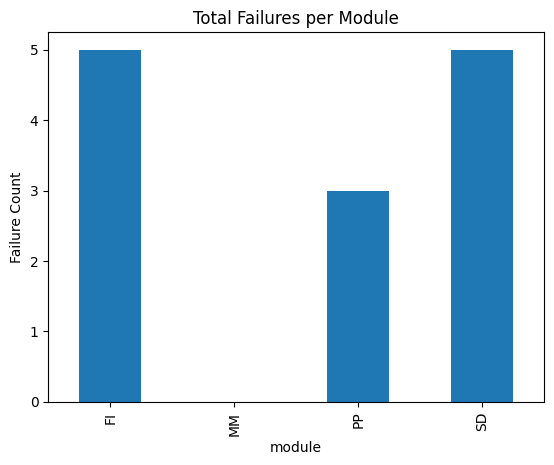

In [5]:
import matplotlib.pyplot as plt

test_cases.groupby("module")["failure_count"].sum().plot(kind="bar")
plt.title("Total Failures per Module")
plt.ylabel("Failure Count")
plt.show()


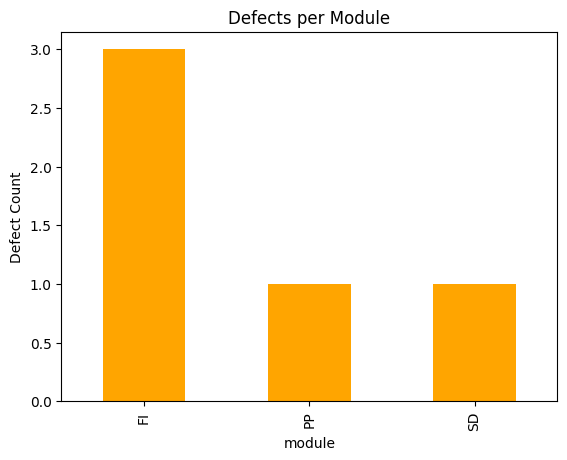

In [6]:
defects.groupby("module")["defect_id"].count().plot(kind="bar", color="orange")
plt.title("Defects per Module")
plt.ylabel("Defect Count")
plt.show()


In [7]:
feature_df.sort_values("risk_score_naive", ascending=False).head(5)


,test_case_id,project,release_id,module,sub_module,description,priority,last_execution_status,last_execution_date,execution_count,failure_count,defect_count,high_sev_defects,failure_rate,risk_score_naive
4,TC_005,Black Panther,REL_2025_01,PP,Capacity,Validate capacity planning run for Q1,High,Failed,05-12-2024,5,3,1.0,1.0,0.600000,0.760
2,TC_003,Cardiac Challenge,REL_2025_02,SD,Delivery,Validate delivery doc creation for export orders,High,Failed,20-01-2025,12,5,1.0,1.0,0.416667,0.650
0,TC_001,Brain Bits,REL_2025_04,FI,AR,Validate invoice creation for EU customer,High,Failed,15-03-2025,10,4,2.0,1.0,0.400000,0.640
1,TC_002,Brain Bits,REL_2025_04,FI,AP,Validate vendor payment run for LATAM,Medium,Passed,16-03-2025,8,1,1.0,0.0,0.125000,0.075
3,TC_004,Cardiac Challenge,REL_2025_02,MM,PO,Validate PO creation with new tax codes,Medium,Passed,18-01-2025,6,0,0.0,0.0,0.000000,0.000
